# Load Packages

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import randint, uniform

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# Model Tuning
import optuna
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Models
from sklearn.linear_model import Ridge, Lasso, LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor

import xgboost as xgb
import lightgbm as lgb


from sklearn.ensemble import BaggingClassifier, BaggingRegressor

from sklearn import set_config
# set_config(display='diagram')

import os
import psutil


import warnings
# warnings.filterwarnings('ignore')

# Ignore the warning
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

# Load Data

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png" width=600>

> Data Readme
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

## Load RAW data

In [2]:
# set data source
data_url = 'data/train.csv'

# set index column
index_col = 'Id'

# load data
data = pd.read_csv(data_url, index_col=index_col)
data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Feature-Target split

In [3]:
# define the target column in the train dataset
target = 'SalePrice'

# split columns into X and y
X = data.drop(columns = target).copy()
y = data[target]

# check the shape of the data
print(f'shape of X is \033[94m{X.shape}\033[0m, shape of y is \033[94m{y.shape}\033[0m')

shape of X is (1460, 79), shape of y is (1460,)


## Missing Values

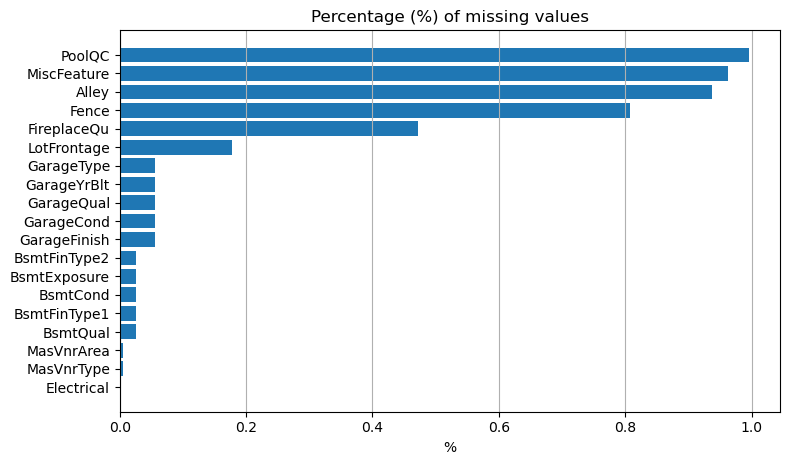

In [4]:
#filter all the features with missing values
feature_null= X.isnull().mean().sort_values(ascending = False)
feature_null=feature_null[feature_null>0]

# visualize
plt.figure(figsize=(8, feature_null.shape[0]/4))
feature_ranks = range(len(feature_null))
bar = plt.barh(feature_null.index, feature_null.values, label=[str(x) for x in feature_ranks])
plt.gca().invert_yaxis()
plt.xlabel('%')
plt.title("Percentage (%) of missing values")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

## Feature Screening

In [5]:
X = data.drop(columns = target).copy()
features_all = X.columns.sort_values().to_list()

columns_to_drop = [
    #to many missing values
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 
    #
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
    'PoolArea', 'MiscVal', 'BsmtHalfBath', 
    'Condition2', 'RoofMatl', 'Heating', 'KitchenAbvGr',
    'Neighborhood', 'Exterior2nd', 'Exterior1st',
    'Condition1', 'SaleType',
    'Street', 'Utilities',
    'BldgType', 'BsmtExposure', 'BsmtFinType2', 'CentralAir', 
    'Electrical', 'Functional', 'LandContour', 'LandSlope', 
    'LotConfig', 'MSZoning', 'PavedDrive', 
    'GarageCond', 'GarageQual'
]
# columns_to_drop = []
X = X.drop(columns=columns_to_drop)

feature_numerical = X.select_dtypes(exclude='object').columns.sort_values().to_list()

# Numerical features following uniform distrution
feature_numerical_norm = ['1stFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 
                          'GrLivArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF']
# feature_numerical_norm = []

feature_numerical_uniform = [key for key in feature_numerical 
                              if key not in feature_numerical_norm]

feature_categorical = X.select_dtypes(include='object').columns.sort_values().to_list()

feature_categorical_Ordinal = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
    'FireplaceQu', 'HeatingQC', 'KitchenQual'
]
feature_categorical_Ordinal.sort()
# feature_categorical_Ordinal=[]

feature_categorical_OneHot = [key for key in feature_categorical 
                              if key not in feature_categorical_Ordinal]

print('--------OVERVIEW----------')

print(f'All features (\033[95m{len(features_all)}\
\033[0m): \033[94m{features_all}\033[0m')

print(f'Features to drop (\033[91m{len(columns_to_drop)}\
\033[0m): \033[94m{columns_to_drop}\033[0m')

print('--------CATEGORICAL----------')

print(f'Categorical cat features (\033[95m{len(feature_categorical)}\
\033[0m): \033[94m{feature_categorical}\033[0m')

print(f'Ordinal cat features (\036[95m{len(feature_categorical_Ordinal)}\
\033[0m): \033[94m{feature_categorical_Ordinal}\033[0m')

print(f'None-ordinal cat features (\033[95m{len(feature_categorical_OneHot)}\
\033[0m): \033[94m{feature_categorical_OneHot}\033[0m')

print('---------NUMERICAL---------')

print(f'Numerical features (\033[95m{len(feature_numerical)}\
\033[0m): \033[94m{feature_numerical}\033[0m')

print(f'Numerical features (\033[95m{len(feature_numerical_norm)}\
\033[0m): \033[94m{feature_numerical_norm}\033[0m')

print(f'Numerical features (\033[95m{len(feature_numerical_uniform)}\
\033[0m): \033[94m{feature_numerical_uniform}\033[0m')

--------OVERVIEW----------
All features (79): ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleTyp

# Data Exploration

## Distribution of each numerical feature

Numerical features (27): ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtUnfSF', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'LotArea', 'LotFrontage', 'MSSubClass', 'MasVnrArea', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']
Numerical features (19): ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFullBath', 'Fireplaces', 'FullBath', 'GarageCars', 'GarageYrBlt', 'HalfBath', 'MSSubClass', 'MasVnrArea', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']
Numerical features (8): ['1stFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF']


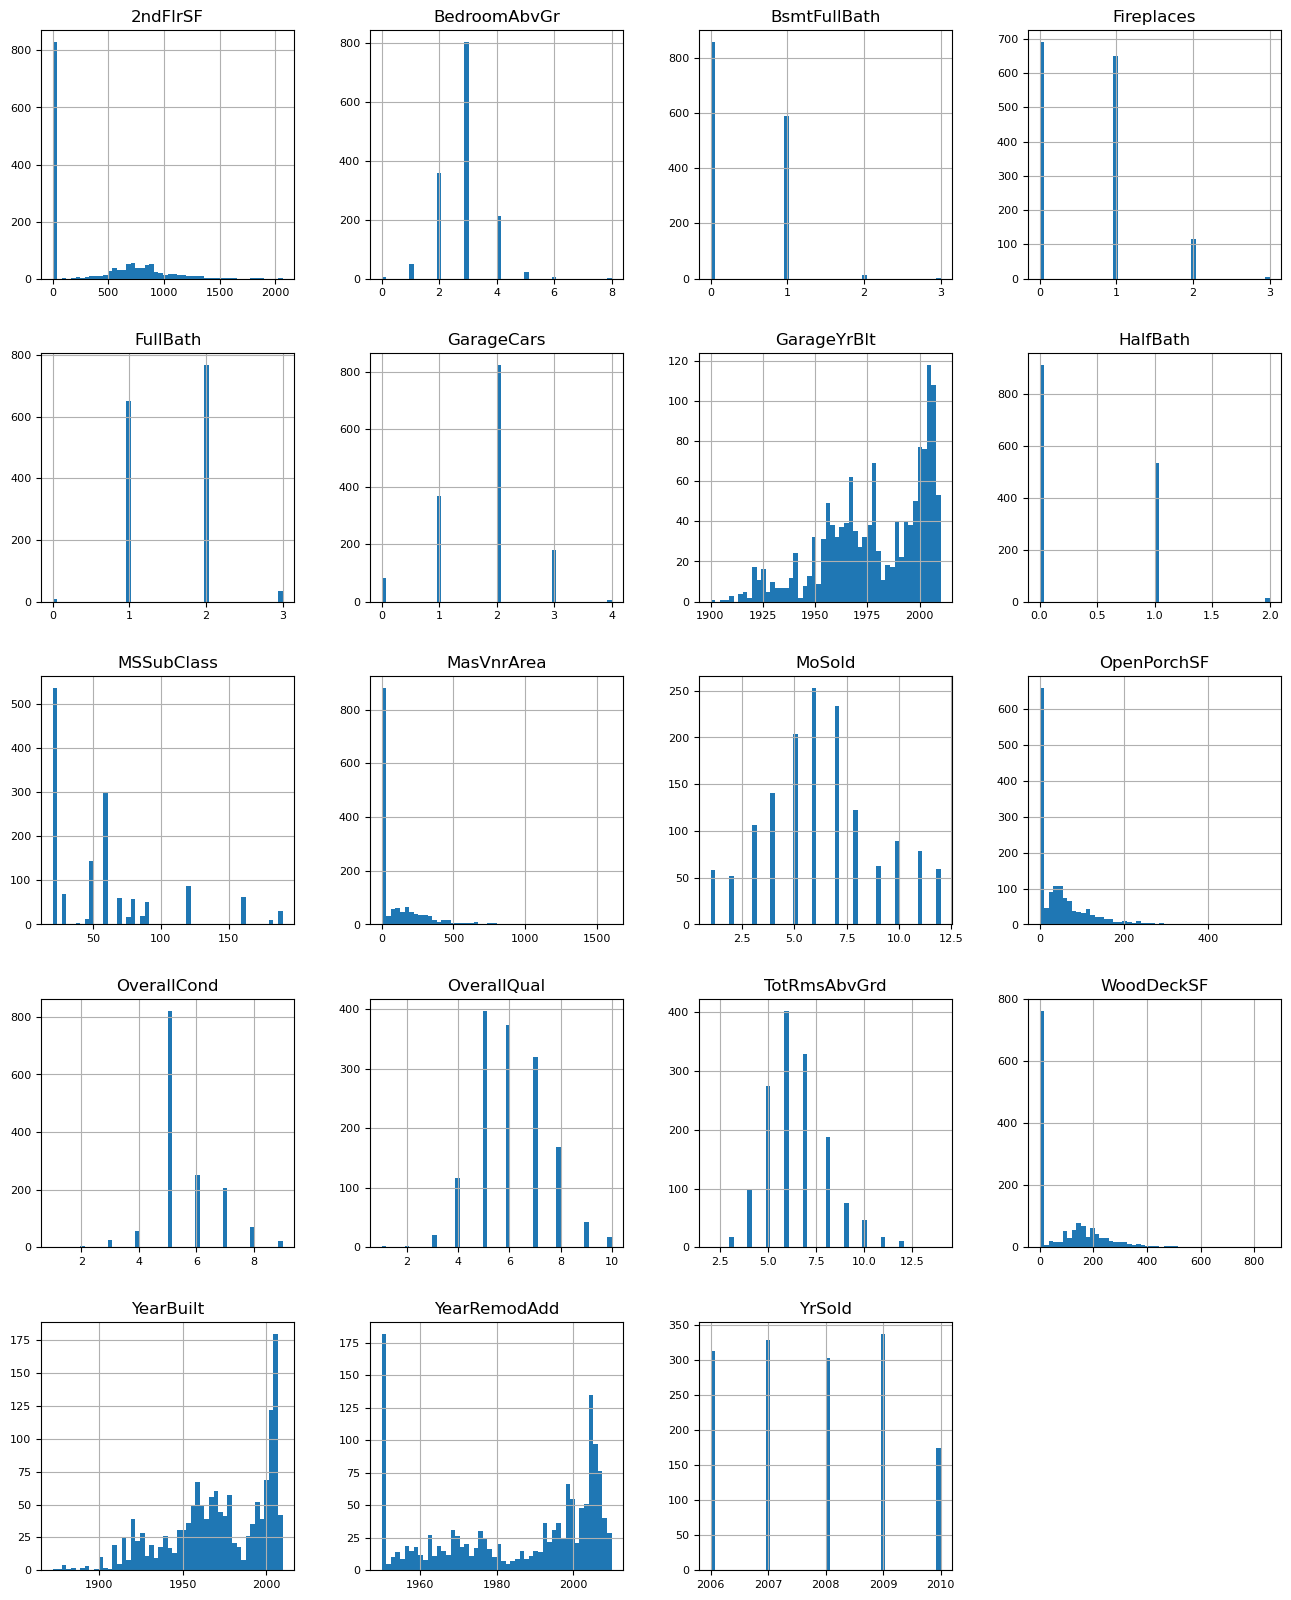

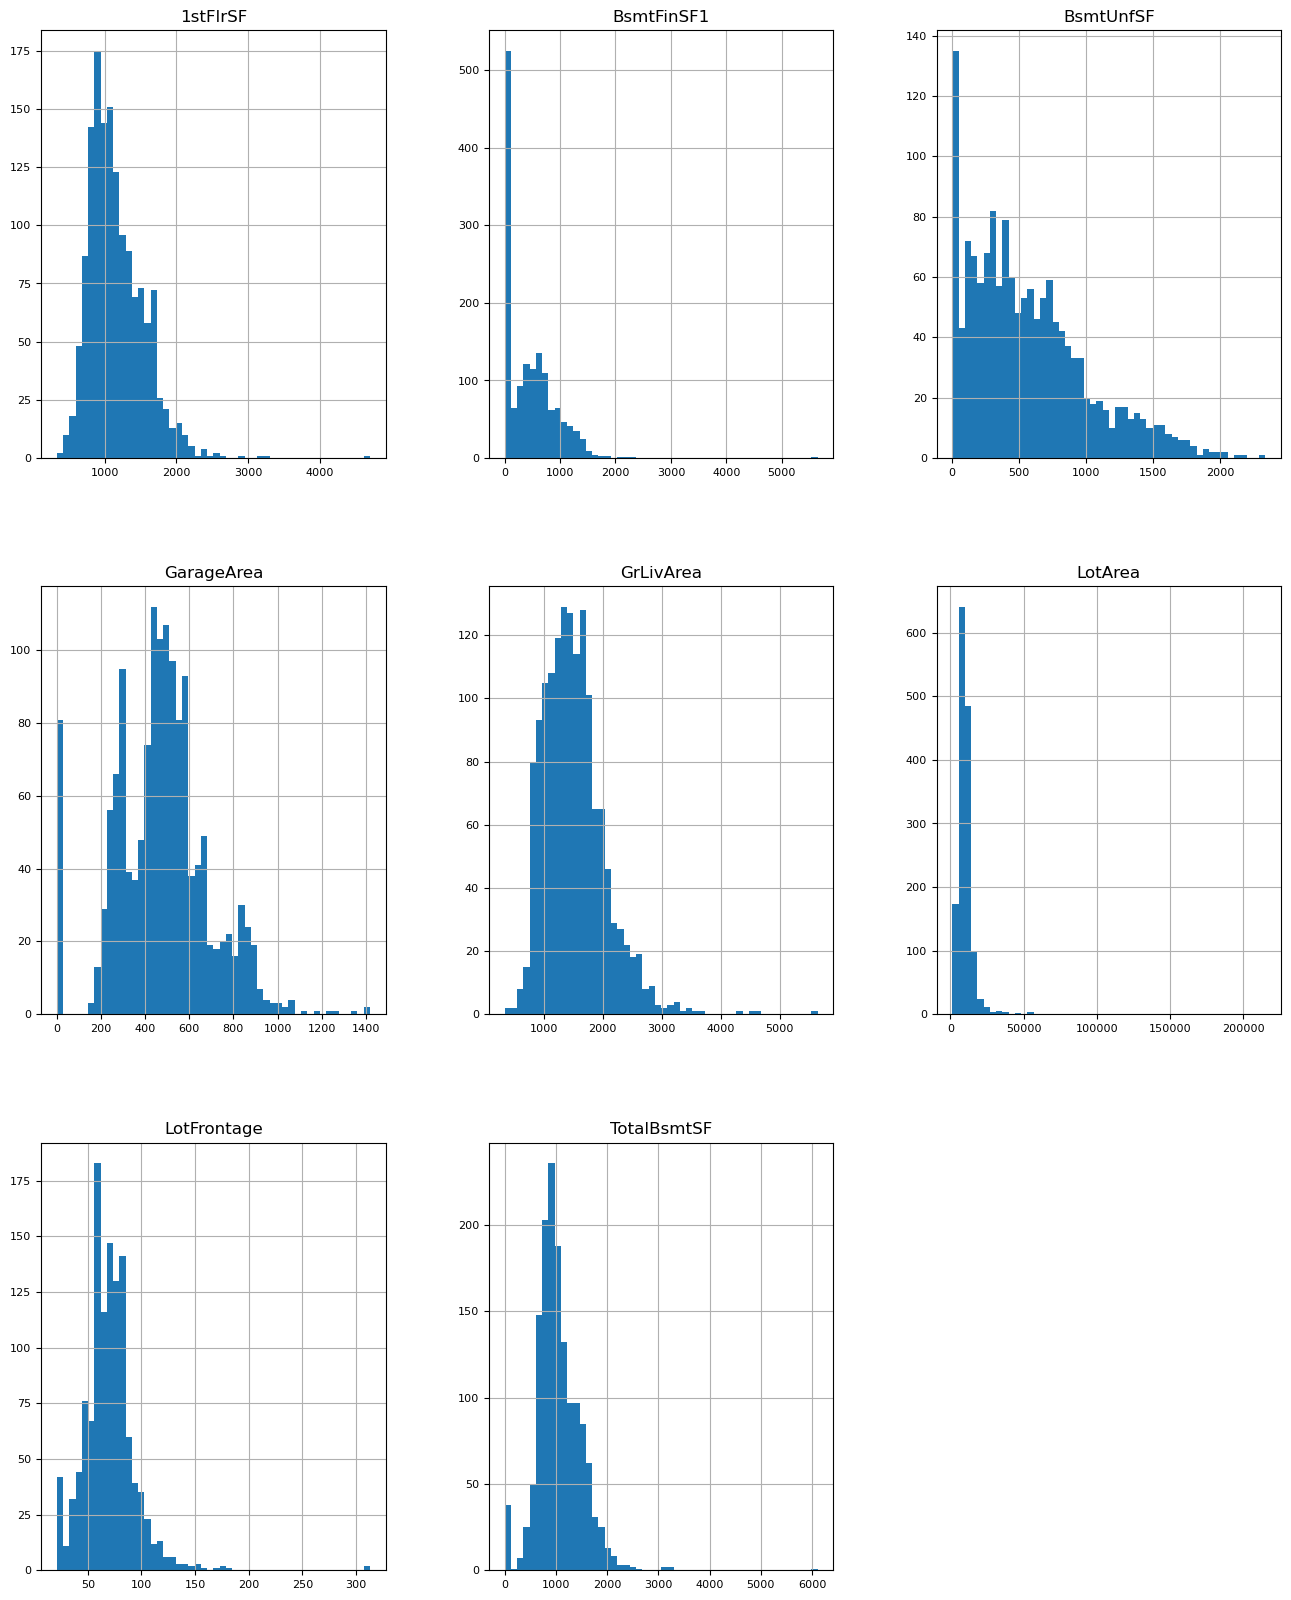

In [6]:
print(f'Numerical features (\033[94m{len(feature_numerical)}\
\033[0m): \033[94m{feature_numerical}\033[0m')

print(f'Numerical features (\033[94m{len(feature_numerical_uniform)}\
\033[0m): \033[94m{feature_numerical_uniform}\033[0m')
X[feature_numerical_uniform].hist(
    figsize=(16, 20), 
    bins=50, 
    xlabelsize=8, 
    ylabelsize=8);

print(f'Numerical features (\033[94m{len(feature_numerical_norm)}\
\033[0m): \033[94m{feature_numerical_norm}\033[0m')
X[feature_numerical_norm].hist(
    figsize=(16, 20), 
    bins=50, 
    xlabelsize=8, 
    ylabelsize=8);

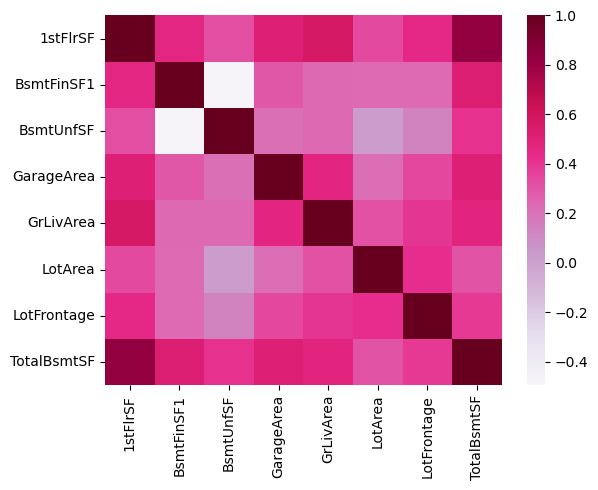

In [7]:
X_num = X[feature_numerical_norm].dropna()

sns.heatmap(X_num.corr(), cmap='PuRd')
pca = PCA()
X_scaled = StandardScaler().fit_transform(X_num)
X_pca = pca.fit_transform(X_scaled)

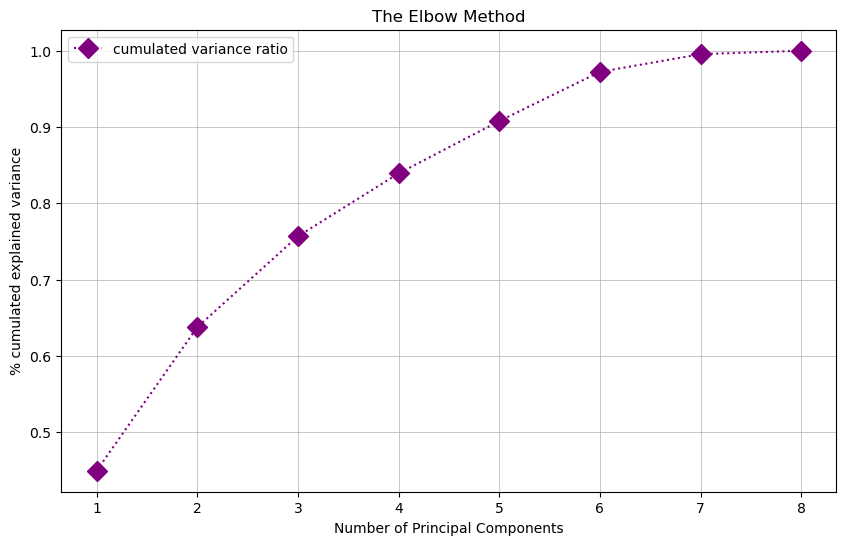

In [8]:
with plt.style.context('seaborn-deep'):
    
    # figsize
    plt.figure(figsize=(10,6))
    
    # getting axes
    ax = plt.gca()
    
    # plotting
    evr_cumulated = np.cumsum(pca.explained_variance_ratio_)
    x_axis_ticks = np.arange(1,evr_cumulated.shape[0]+1)
    ax.plot(x_axis_ticks,evr_cumulated,label="cumulated variance ratio",color="purple",linestyle=":",marker="D",markersize=10)
    
    
    # customizing
    ax.set_xlabel('Number of Principal Components')
    ax.set_ylabel('% cumulated explained variance')
    ax.legend(loc="upper left")
    ax.set_title('The Elbow Method')
    ax.set_xticks(x_axis_ticks)
#     ax.scatter(15,evr_cumulated[15-1],c='blue',s=400)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

## Distribution of each catigorical feature

Categorical cat features (16): ['BsmtCond', 'BsmtFinType1', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 'Foundation', 'GarageFinish', 'GarageType', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LotShape', 'MasVnrType', 'RoofStyle', 'SaleCondition']


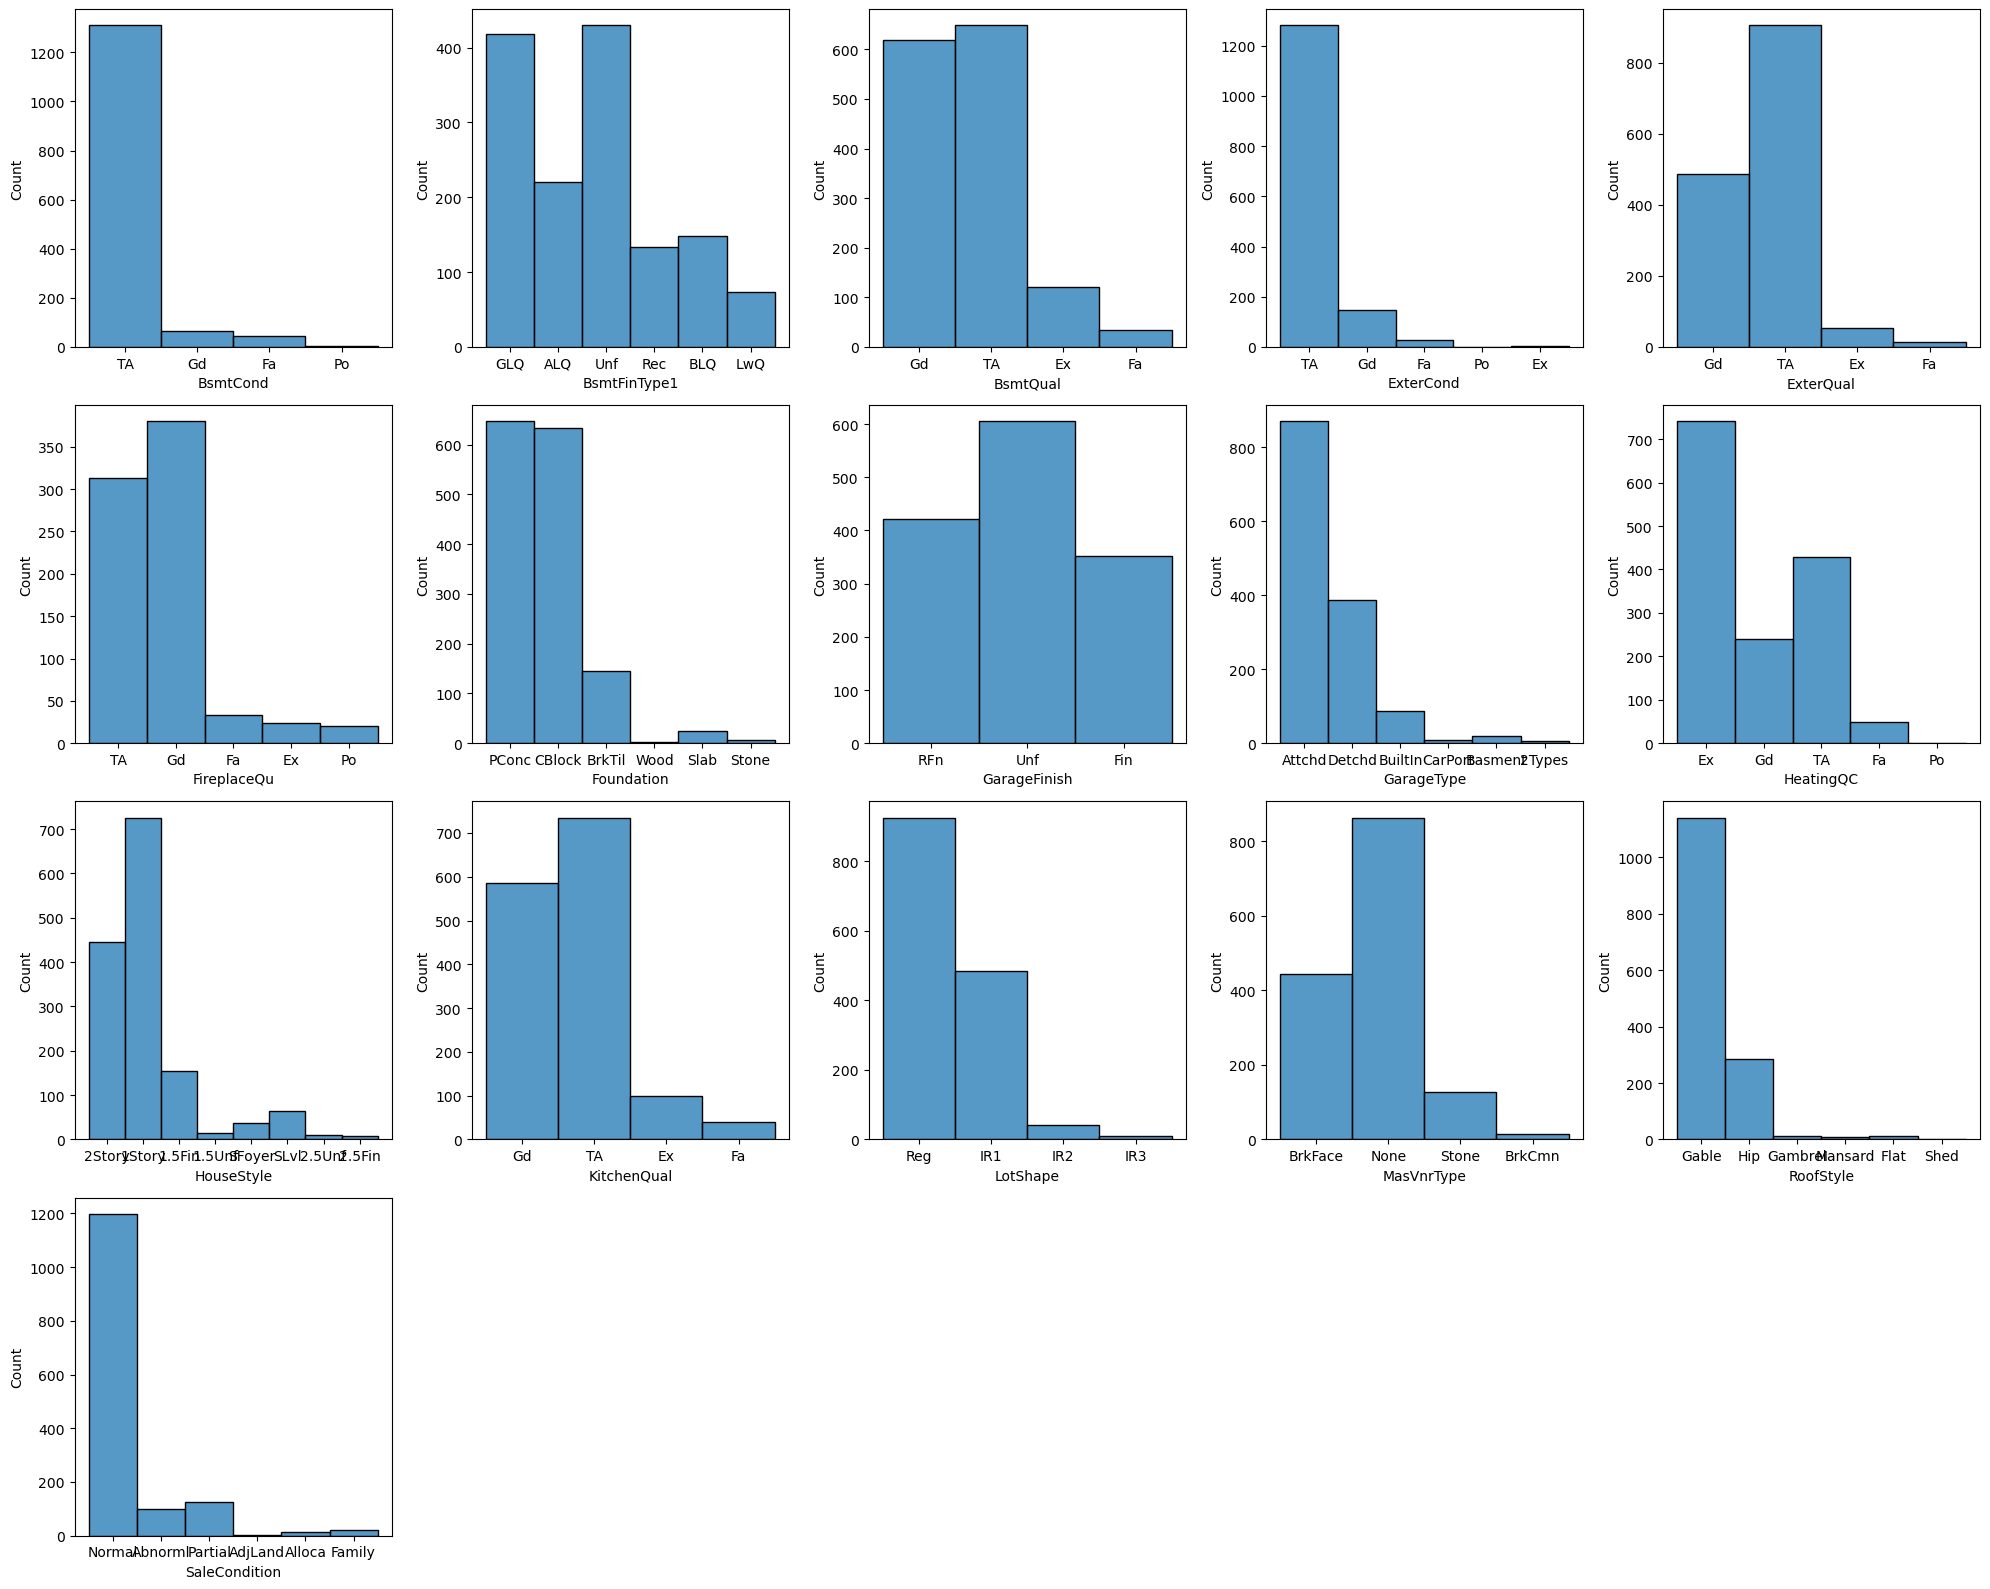

In [9]:
plot_list=feature_categorical

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

# Assuming 'X' is your DataFrame
num_cols = 5  # Number of columns in the grid
num_rows = (len(plot_list) - 1) // num_cols + 1  # Number of rows in the grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))

# Plot each categorical feature
for i, feature in enumerate(plot_list):
    ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
    sns.histplot(data=X, x=feature, kde=False, ax=ax)

# Hide unused subplots
if len(plot_list) < num_rows * num_cols:
    for j in range(len(plot_list), num_rows * num_cols):
        axes[j // num_cols, j % num_cols].axis('off')

plt.tight_layout()
plt.show()

## Distribution of each catigorical Ordinal feature

Categorical cat features (7): ['BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 'HeatingQC', 'KitchenQual']


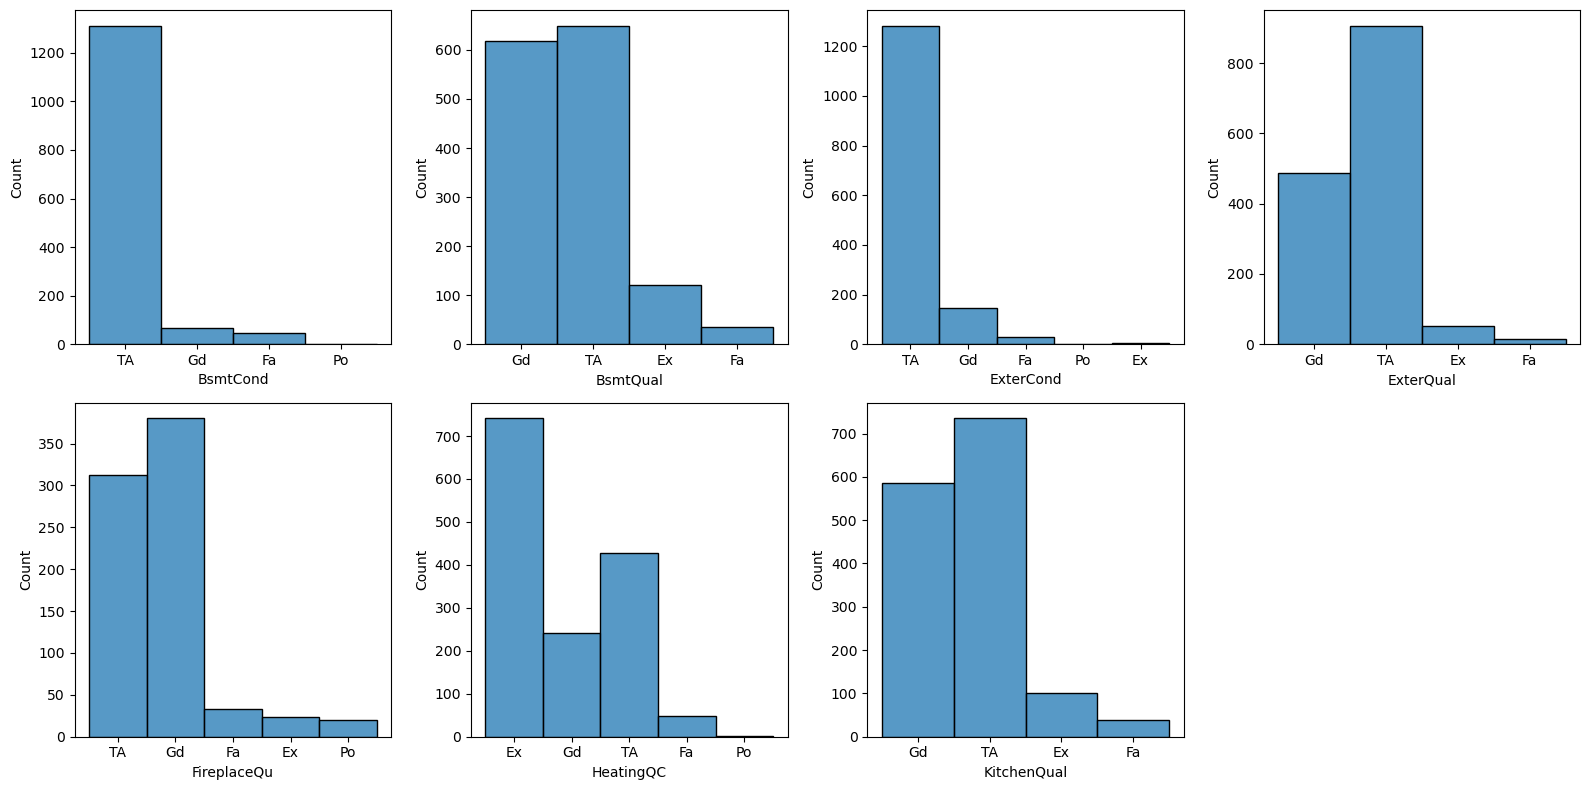

In [10]:
plot_list = feature_categorical_Ordinal

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

if len(plot_list)>0:
    # Assuming 'X' is your DataFrame
    num_cols = 4  # Number of columns in the grid
    num_rows = (len(plot_list) - 1) // num_cols + 1  # Number of rows in the grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))

    # Plot each categorical feature
    for i, feature in enumerate(plot_list):
        ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
        sns.histplot(data=X, x=feature, kde=False, ax=ax)

    # Hide unused subplots
    if len(plot_list) < num_rows * num_cols:
        for j in range(len(plot_list), num_rows * num_cols):
            axes[j // num_cols, j % num_cols].axis('off')

    plt.tight_layout()
    plt.show()

In [11]:
feat_ordinal_dict = {
    # considers "missing" as the worse category
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
#     "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
#     "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
#     "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
#     "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
#     "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
#     "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
#     "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex']
#     "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
#     "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
#     "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
#     "PavedDrive": ['missing', 'N', 'P', 'Y'],
#     "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}


ordinal_features = list(feat_ordinal_dict.keys())
ordinal_values = list(feat_ordinal_dict.values())
print('complete')

complete


## Distribution of each catigorical OneHot feature

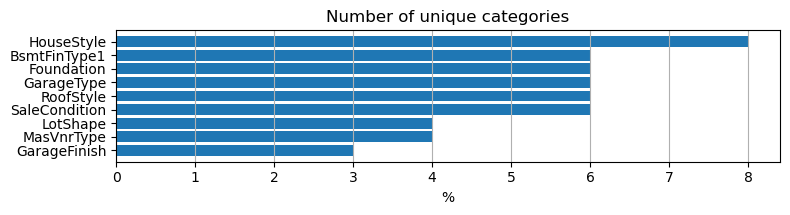

In [12]:
# list the number of categories of each OneHot feature
feature_cat_value_count= X[feature_categorical_OneHot].nunique().sort_values(ascending=False)
feature_cat_value_count=feature_cat_value_count[feature_cat_value_count>0]

# visualize
plt.figure(figsize=(8, feature_cat_value_count.shape[0]/4))
feature_ranks = range(len(feature_cat_value_count))
bar = plt.barh(feature_cat_value_count.index, feature_cat_value_count.values, label=[str(x) for x in feature_ranks])
plt.gca().invert_yaxis()
plt.xlabel('%')
plt.title("Number of unique categories")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

Categorical cat features (9): ['BsmtFinType1', 'Foundation', 'GarageFinish', 'GarageType', 'HouseStyle', 'LotShape', 'MasVnrType', 'RoofStyle', 'SaleCondition']


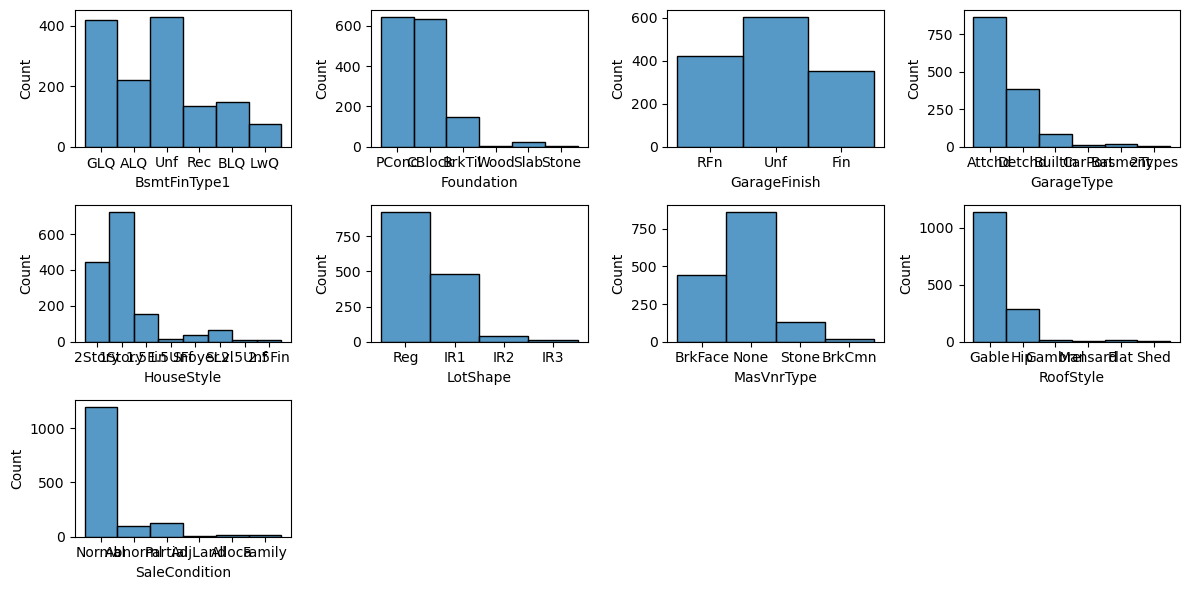

In [13]:
plot_list=feature_categorical_OneHot

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

if len(plot_list)>0:
    # Assuming 'X' is your DataFrame
    num_cols = 4  # Number of columns in the grid
    num_rows = (len(plot_list) - 1) // num_cols + 1  # Number of rows in the grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 2*num_rows))

    # Plot each categorical feature
    for i, feature in enumerate(plot_list):
        ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
        sns.histplot(data=X, x=feature, kde=False, ax=ax)

    # Hide unused subplots
    if len(plot_list) < num_rows * num_cols:
        for j in range(len(plot_list), num_rows * num_cols):
            axes[j // num_cols, j % num_cols].axis('off')

    plt.tight_layout()
    plt.show()

# Data Preprocessing

In [137]:
#transformer for numerical data
preproc_num_norm = make_pipeline(
    SimpleImputer(strategy='mean'),
#     MinMaxScaler()
    RobustScaler(),
#     StandardScaler(),
#     PCA()
)

preproc_num_uniform = make_pipeline(
    SimpleImputer(strategy='mean'),
#     MinMaxScaler(),
    RobustScaler(),
#     StandardScaler(),
#     PCA()
)

preproc_cat_ordinal = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='Missing'),
    OrdinalEncoder(
        categories=ordinal_values,
        dtype=np.int64,
        handle_unknown="use_encoded_value", unknown_value=-1
    ),
    MinMaxScaler()
)

preproc_cat_onehot = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(
        drop = 'if_binary',
        sparse_output=False,
        handle_unknown='ignore')
)

preproc_pipeline = ColumnTransformer([
    ('ordinal processor', preproc_cat_ordinal, feature_categorical_Ordinal),
    ('numerical processor norm', preproc_num_norm, feature_numerical_norm),
    ('numerical processor uniform', preproc_num_uniform, feature_numerical_uniform),
    ('categorical processor', preproc_cat_onehot, feature_categorical_OneHot),
#     remainder='passthrough'
])

X_preprocessed = preproc_pipeline.fit_transform(X)
y_log=np.log(y)

# Model

## Custom Loss Function

In [15]:
def my_rmsle_neg(y_true, y_pred):
    return -(np.mean((np.log(y_true+1)-np.log(y_pred+1))**2))**0.5 

from sklearn.metrics import make_scorer
rmsle_neg = make_scorer(my_rmsle_neg)

def my_rmsle(y_true, y_pred):
    return (np.mean((np.log(y_true+1)-np.log(y_pred+1))**2))**0.5 

from sklearn.metrics import make_scorer
rmsle = make_scorer(my_rmsle)

print('complete')

complete


In [16]:
def my_rmsle(y_true, y_pred):
    return -(np.mean((np.log(y_true+1)-np.log(y_pred+1))**2))**0.5 

from sklearn.metrics import make_scorer
rmsle = make_scorer(my_rmsle)

print('complete')

complete


## Cross Validation

In [177]:
# this code is to use cross validation to screen 
# all available models with default hyperparameters
# please comment out the models which are not relevant

models = {
    'KNN Regressor': KNeighborsRegressor(),
#     'KNN Classifier': KNeighborsClassifier(),
#     'SVC': SVC(),
#     'SVC_poly': SVC(kernel='poly'),
#     'SVC_linear': SVC(kernel='linear'),
    'Decision Tree': DecisionTreeRegressor(),
#     'LinearRegression': LinearRegression(),
#     'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': xgb.XGBRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'lightGBM Regressor': lgb.LGBMRegressor(),
#     'lightGBM Classifier': lgb.LGBMClassifier()
}

print('Baseline Score(s) of each model are ....')
for name in models:
#     cv_result = cross_val_score(models[name], 
#                                 X_fit, 
#                                 y, 
#                                 cv=5, 
#                                 scoring=rmsle_neg, 
#                                 n_jobs=-1)
    cv_result = cross_val_score(models[name], 
                                X_preprocessed, 
                                y_log, 
                                cv=5, 
                                scoring='neg_mean_squared_error', 
                                n_jobs=-1)
    print(f'Average score: \033[94m{-(-cv_result.mean())**.5}\033[0m by \033[94m{name}\033[0m.')

Baseline Score(s) of each model are ....
Average score: -0.17068527818522009 by KNN Regressor.
Average score: -0.20218140752097988 by Decision Tree.
Average score: -0.144338177452222 by RandomForestRegressor.
Average score: -0.1465482333109738 by XGBRegressor.
Average score: -0.1333080625396156 by GradientBoostingRegressor.
Average score: -0.1381534164104772 by lightGBM Regressor.


## Grid/Random Search

### Gradient Boost

In [119]:
# Model tuning using uptuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }
    model = GradientBoostingRegressor(**params)
#     score = np.mean(cross_val_score(model, X_fit, y, scoring=rmsle_neg))
#     return  score
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5

gd_study = optuna.create_study(direction='maximize')
gd_study.optimize(objective, n_jobs=-1, n_trials=1000)

best_gd_model = GradientBoostingRegressor(**gd_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(gd_study.best_trial)

# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-05-29 07:33:19,525] Trial 996 finished with value: -0.14128902086321699 and 
# parameters: {'n_estimators': 384, 'learning_rate': 0.07886590996608028, 'max_depth': 8, 
# 'min_samples_split': 11, 'min_samples_leaf': 1, 'subsample': 0.8477516222094403}. 
# Best is trial 749 with value: -0.13011753420930586.
# 
# FrozenTrial(number=749, state=TrialState.COMPLETE, 
# values=[-0.13011753420930586], datetime_start=datetime.datetime(2023, 5, 29, 7, 28, 3, 12290), 
# datetime_complete=datetime.datetime(2023, 5, 29, 7, 28, 11, 888495), 
# params={
# 'n_estimators': 380, 'learning_rate': 0.05968108162828581, 'max_depth': 3, 
# 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.6630066373055117}, 
# user_attrs={}, system_attrs={}, intermediate_values={}, 
# distributions={'n_estimators': IntDistribution(high=500, log=False, low=50, step=1), 
# 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.001, step=None), 
# 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 
# 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 
# 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 
# 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None)}, 
# trial_id=749, value=None)

[I 2023-05-29 07:12:54,170] A new study created in memory with name: no-name-ba33e162-e4a0-4688-90a3-27f8f61ae5bd
[I 2023-05-29 07:12:56,937] Trial 6 finished with value: -0.14259249926900955 and parameters: {'n_estimators': 138, 'learning_rate': 0.04588085191817774, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.6316796803124055}. Best is trial 6 with value: -0.14259249926900955.
[I 2023-05-29 07:13:01,566] Trial 1 finished with value: -0.14114465539357068 and parameters: {'n_estimators': 370, 'learning_rate': 0.15581428599547584, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.6905472827717841}. Best is trial 1 with value: -0.14114465539357068.
[I 2023-05-29 07:13:01,785] Trial 8 finished with value: -0.14306765777476801 and parameters: {'n_estimators': 163, 'learning_rate': 0.1444924963802366, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.7485504841439847}. Best is trial 1 with value: -0.14

[I 2023-05-29 07:13:32,043] Trial 24 finished with value: -0.1390613028779838 and parameters: {'n_estimators': 490, 'learning_rate': 0.01646425846097689, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 7, 'subsample': 0.999070367534701}. Best is trial 7 with value: -0.13483726225829457.
[I 2023-05-29 07:13:36,392] Trial 33 finished with value: -0.1480811210057317 and parameters: {'n_estimators': 305, 'learning_rate': 0.01457242173767644, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 9, 'subsample': 0.9980240606293087}. Best is trial 7 with value: -0.13483726225829457.
[I 2023-05-29 07:13:36,586] Trial 30 finished with value: -0.17566049835243996 and parameters: {'n_estimators': 427, 'learning_rate': 0.005646263073754362, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 3, 'subsample': 0.9320383200149228}. Best is trial 7 with value: -0.13483726225829457.
[I 2023-05-29 07:13:36,710] Trial 28 finished with value: -0.23961230654622478 and parameters:

[I 2023-05-29 07:14:02,465] Trial 53 finished with value: -0.13749781510452544 and parameters: {'n_estimators': 396, 'learning_rate': 0.0945481584592511, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.7344699496473458}. Best is trial 49 with value: -0.1329606605214126.
[I 2023-05-29 07:14:02,559] Trial 51 finished with value: -0.1347327944949087 and parameters: {'n_estimators': 406, 'learning_rate': 0.04226433653065142, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.8957856871871653}. Best is trial 49 with value: -0.1329606605214126.
[I 2023-05-29 07:14:02,873] Trial 54 finished with value: -0.13576950192681708 and parameters: {'n_estimators': 391, 'learning_rate': 0.12023741074936627, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.7732383166612732}. Best is trial 49 with value: -0.1329606605214126.
[I 2023-05-29 07:14:07,002] Trial 56 finished with value: -0.1400481012976002 and parameters: 

[I 2023-05-29 07:14:40,059] Trial 78 finished with value: -0.13460327403040007 and parameters: {'n_estimators': 468, 'learning_rate': 0.05041957816988389, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.5824759055381651}. Best is trial 72 with value: -0.13245610308519987.
[I 2023-05-29 07:14:42,089] Trial 79 finished with value: -0.1348137777865004 and parameters: {'n_estimators': 466, 'learning_rate': 0.04977338550073232, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.7384847120989171}. Best is trial 72 with value: -0.13245610308519987.
[I 2023-05-29 07:14:42,418] Trial 80 finished with value: -0.1358713011785173 and parameters: {'n_estimators': 473, 'learning_rate': 0.040161906265528936, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.8521616335831034}. Best is trial 72 with value: -0.13245610308519987.
[I 2023-05-29 07:14:43,160] Trial 82 finished with value: -0.13635667792204953 and parameter

[I 2023-05-29 07:15:08,952] Trial 98 finished with value: -0.13423232662424087 and parameters: {'n_estimators': 457, 'learning_rate': 0.05598536726443221, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.6405438364343189}. Best is trial 100 with value: -0.13242363888474742.
[I 2023-05-29 07:15:09,721] Trial 107 finished with value: -0.13552565858340965 and parameters: {'n_estimators': 206, 'learning_rate': 0.04595746247779501, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 'subsample': 0.6665613746548332}. Best is trial 100 with value: -0.13242363888474742.
[I 2023-05-29 07:15:10,847] Trial 103 finished with value: -0.13333380237212322 and parameters: {'n_estimators': 375, 'learning_rate': 0.034980884776136964, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1, 'subsample': 0.7120146259234996}. Best is trial 100 with value: -0.13242363888474742.
[I 2023-05-29 07:15:12,372] Trial 105 finished with value: -0.13442132294546755 and p

[I 2023-05-29 07:15:32,270] Trial 132 finished with value: -0.13844417001558645 and parameters: {'n_estimators': 252, 'learning_rate': 0.023758084680560808, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7078864164362447}. Best is trial 118 with value: -0.13173398820046459.
[I 2023-05-29 07:15:32,824] Trial 133 finished with value: -0.13934946569194445 and parameters: {'n_estimators': 251, 'learning_rate': 0.022240026870246274, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7211544044141722}. Best is trial 118 with value: -0.13173398820046459.
[I 2023-05-29 07:15:32,874] Trial 130 finished with value: -0.13390028215978184 and parameters: {'n_estimators': 278, 'learning_rate': 0.02536828606220988, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.7117109888724014}. Best is trial 118 with value: -0.13173398820046459.
[I 2023-05-29 07:15:33,350] Trial 128 finished with value: -0.13896134993615972 and

[I 2023-05-29 07:16:00,980] Trial 156 finished with value: -0.13430733112340482 and parameters: {'n_estimators': 406, 'learning_rate': 0.016082516981754016, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.7548345120687655}. Best is trial 142 with value: -0.13103995444469482.
[I 2023-05-29 07:16:03,647] Trial 157 finished with value: -0.13309829919884092 and parameters: {'n_estimators': 440, 'learning_rate': 0.01962687439329516, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.7312727187641395}. Best is trial 142 with value: -0.13103995444469482.
[I 2023-05-29 07:16:05,693] Trial 158 finished with value: -0.13374801819188037 and parameters: {'n_estimators': 401, 'learning_rate': 0.01876883087876132, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.7325101567411165}. Best is trial 142 with value: -0.13103995444469482.
[I 2023-05-29 07:16:07,771] Trial 159 finished with value: -0.1332001615349534 and

[I 2023-05-29 07:16:33,130] Trial 179 finished with value: -0.13360219596682887 and parameters: {'n_estimators': 450, 'learning_rate': 0.026801499127353266, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 2, 'subsample': 0.693343150837673}. Best is trial 142 with value: -0.13103995444469482.
[I 2023-05-29 07:16:35,893] Trial 182 finished with value: -0.13221431633431627 and parameters: {'n_estimators': 405, 'learning_rate': 0.02574255022748825, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 1, 'subsample': 0.7154093076254288}. Best is trial 142 with value: -0.13103995444469482.
[I 2023-05-29 07:16:37,948] Trial 184 finished with value: -0.13394514432926166 and parameters: {'n_estimators': 450, 'learning_rate': 0.02499742683538889, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.7168979325942815}. Best is trial 142 with value: -0.13103995444469482.
[I 2023-05-29 07:16:39,454] Trial 185 finished with value: -0.13290555935401005 and

[I 2023-05-29 07:17:08,882] Trial 210 finished with value: -0.13257332972260988 and parameters: {'n_estimators': 372, 'learning_rate': 0.029763846203678314, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.7386285278252396}. Best is trial 188 with value: -0.13101457562060848.
[I 2023-05-29 07:17:10,546] Trial 208 finished with value: -0.13392080037970489 and parameters: {'n_estimators': 461, 'learning_rate': 0.014398241253679313, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 1, 'subsample': 0.7271469533843832}. Best is trial 188 with value: -0.13101457562060848.
[I 2023-05-29 07:17:11,068] Trial 212 finished with value: -0.13305414397044474 and parameters: {'n_estimators': 422, 'learning_rate': 0.033920107504292744, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 1, 'subsample': 0.730293722646856}. Best is trial 188 with value: -0.13101457562060848.
[I 2023-05-29 07:17:11,718] Trial 213 finished with value: -0.13252516351612578 

[I 2023-05-29 07:17:43,535] Trial 234 finished with value: -0.13165247784834175 and parameters: {'n_estimators': 434, 'learning_rate': 0.026463911742233025, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.7445047358885025}. Best is trial 188 with value: -0.13101457562060848.
[I 2023-05-29 07:17:44,700] Trial 235 finished with value: -0.24769849484581652 and parameters: {'n_estimators': 434, 'learning_rate': 0.0019939498159550623, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.6884623435098267}. Best is trial 188 with value: -0.13101457562060848.
[I 2023-05-29 07:17:45,545] Trial 236 finished with value: -0.13329188867624447 and parameters: {'n_estimators': 432, 'learning_rate': 0.026237459549861394, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.7461695045184741}. Best is trial 188 with value: -0.13101457562060848.
[I 2023-05-29 07:17:45,980] Trial 237 finished with value: -0.1329516597552335

[I 2023-05-29 07:18:20,187] Trial 260 finished with value: -0.13273024890405227 and parameters: {'n_estimators': 415, 'learning_rate': 0.018196082351686824, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.7594162714594854}. Best is trial 188 with value: -0.13101457562060848.
[I 2023-05-29 07:18:22,056] Trial 261 finished with value: -0.13252230990627087 and parameters: {'n_estimators': 456, 'learning_rate': 0.019235745643719174, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.7554929721881612}. Best is trial 188 with value: -0.13101457562060848.
[I 2023-05-29 07:18:22,432] Trial 262 finished with value: -0.1340195553524699 and parameters: {'n_estimators': 457, 'learning_rate': 0.018717854839339687, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.7600644412824251}. Best is trial 188 with value: -0.13101457562060848.
[I 2023-05-29 07:18:23,561] Trial 264 finished with value: -0.13273650576711682 

[I 2023-05-29 07:18:50,284] Trial 286 finished with value: -0.13829146277089885 and parameters: {'n_estimators': 410, 'learning_rate': 0.15789780914419113, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7191124896876465}. Best is trial 276 with value: -0.13066883936741253.
[I 2023-05-29 07:18:51,586] Trial 287 finished with value: -0.13262440716311247 and parameters: {'n_estimators': 408, 'learning_rate': 0.029281196139252508, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7165102087172995}. Best is trial 276 with value: -0.13066883936741253.
[I 2023-05-29 07:18:55,775] Trial 288 finished with value: -0.1318100210785749 and parameters: {'n_estimators': 408, 'learning_rate': 0.028375251366531438, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7159378055887095}. Best is trial 276 with value: -0.13066883936741253.
[I 2023-05-29 07:18:57,680] Trial 289 finished with value: -0.13284050733837183 and 

[I 2023-05-29 07:19:23,420] Trial 313 finished with value: -0.13535850882761977 and parameters: {'n_estimators': 424, 'learning_rate': 0.10681561814525031, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.7940023017864133}. Best is trial 276 with value: -0.13066883936741253.
[I 2023-05-29 07:19:25,386] Trial 317 finished with value: -0.13732321862563882 and parameters: {'n_estimators': 425, 'learning_rate': 0.034253989775554376, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 7, 'subsample': 0.7949814939231816}. Best is trial 276 with value: -0.13066883936741253.
[I 2023-05-29 07:19:26,168] Trial 314 finished with value: -0.1414420049637624 and parameters: {'n_estimators': 425, 'learning_rate': 0.17549979618905406, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7900274437821221}. Best is trial 276 with value: -0.13066883936741253.
[I 2023-05-29 07:19:27,817] Trial 318 finished with value: -0.13087614542682585 and p

[I 2023-05-29 07:19:53,257] Trial 336 finished with value: -0.1317232055335414 and parameters: {'n_estimators': 402, 'learning_rate': 0.043791964095973454, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.8202384791995484}. Best is trial 322 with value: -0.13042655152639818.
[I 2023-05-29 07:19:53,586] Trial 337 finished with value: -0.13151995818719514 and parameters: {'n_estimators': 399, 'learning_rate': 0.0613882643342336, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.8190951313502183}. Best is trial 322 with value: -0.13042655152639818.
[I 2023-05-29 07:19:55,599] Trial 339 finished with value: -0.13304043202685834 and parameters: {'n_estimators': 399, 'learning_rate': 0.06113991680050952, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.817351980119458}. Best is trial 322 with value: -0.13042655152639818.
[I 2023-05-29 07:19:56,122] Trial 342 finished with value: -0.13272055644432829 and par

[I 2023-05-29 07:20:19,722] Trial 363 finished with value: -0.13211251766086424 and parameters: {'n_estimators': 375, 'learning_rate': 0.07477494019633933, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.7731845176746374}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:20:21,485] Trial 365 finished with value: -0.1332846760533595 and parameters: {'n_estimators': 381, 'learning_rate': 0.08004050699753867, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.8072250272910155}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:20:24,186] Trial 366 finished with value: -0.1322132326373669 and parameters: {'n_estimators': 382, 'learning_rate': 0.06325480381930038, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7727307391194989}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:20:25,930] Trial 367 finished with value: -0.13308451740584556 and p

[I 2023-05-29 07:20:48,159] Trial 392 finished with value: -0.13404562508687423 and parameters: {'n_estimators': 321, 'learning_rate': 0.06200024327192249, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.8011014528612905}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:20:50,253] Trial 393 finished with value: -0.13356274849551958 and parameters: {'n_estimators': 368, 'learning_rate': 0.06125504303049935, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.7996423993873542}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:20:53,671] Trial 385 finished with value: -0.14049481011560452 and parameters: {'n_estimators': 345, 'learning_rate': 0.05100931111255516, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7857330217032759}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:20:53,695] Trial 394 finished with value: -0.1342882775499492 and pa

[I 2023-05-29 07:21:20,407] Trial 420 finished with value: -0.13227577672867552 and parameters: {'n_estimators': 356, 'learning_rate': 0.05297867170646376, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.8693101113910346}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:21:21,622] Trial 414 finished with value: -0.13589722983562574 and parameters: {'n_estimators': 377, 'learning_rate': 0.05326564600203187, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.760215311354469}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:21:23,357] Trial 417 finished with value: -0.13672623512941495 and parameters: {'n_estimators': 378, 'learning_rate': 0.0468517513804364, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 1, 'subsample': 0.757210142979274}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:21:24,776] Trial 423 finished with value: -0.13205177611678237 and para

[I 2023-05-29 07:21:46,999] Trial 443 finished with value: -0.13275362414511033 and parameters: {'n_estimators': 331, 'learning_rate': 0.06530108904868956, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.7930165881877174}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:21:47,493] Trial 440 finished with value: -0.13353711519193281 and parameters: {'n_estimators': 385, 'learning_rate': 0.08066823328138187, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.8441626972931612}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:21:50,246] Trial 445 finished with value: -0.13663181969075752 and parameters: {'n_estimators': 336, 'learning_rate': 0.1016188853835598, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.7915681961786591}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:21:51,596] Trial 446 finished with value: -0.13741915055500611 and pa

[I 2023-05-29 07:22:17,153] Trial 473 finished with value: -0.13478459662151382 and parameters: {'n_estimators': 156, 'learning_rate': 0.05917011764446461, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7675938653810229}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:22:17,511] Trial 470 finished with value: -0.13326658016549364 and parameters: {'n_estimators': 396, 'learning_rate': 0.04927174589790393, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.5910289043375324}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:22:18,791] Trial 468 finished with value: -0.13394727317455152 and parameters: {'n_estimators': 395, 'learning_rate': 0.06631693434447622, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.8288882753923297}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:22:18,971] Trial 469 finished with value: -0.13517171495617616 and p

[I 2023-05-29 07:22:46,830] Trial 493 finished with value: -0.13242372986958925 and parameters: {'n_estimators': 469, 'learning_rate': 0.052453041634327846, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.7859516165857542}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:22:47,970] Trial 496 finished with value: -0.13292361131470248 and parameters: {'n_estimators': 356, 'learning_rate': 0.0523278687925749, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.7855783587789283}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:22:48,316] Trial 494 finished with value: -0.13242006079227625 and parameters: {'n_estimators': 466, 'learning_rate': 0.052371183677595766, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.7792145429678283}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:22:50,173] Trial 497 finished with value: -0.13107742998096278 and 

[I 2023-05-29 07:23:12,932] Trial 515 finished with value: -0.1318766573362967 and parameters: {'n_estimators': 493, 'learning_rate': 0.058855182771127355, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.944038519989546}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:23:13,734] Trial 521 finished with value: -0.13105862812629632 and parameters: {'n_estimators': 366, 'learning_rate': 0.04466512161247491, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.8167987298555459}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:23:14,216] Trial 522 finished with value: -0.1332268246061569 and parameters: {'n_estimators': 366, 'learning_rate': 0.10075263040017157, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.8145086129732539}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:23:16,161] Trial 523 finished with value: -0.13307281194075132 and par

[I 2023-05-29 07:23:46,728] Trial 546 finished with value: -0.13702534919572587 and parameters: {'n_estimators': 396, 'learning_rate': 0.13317989428108687, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.8073296503241076}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:23:46,834] Trial 547 finished with value: -0.1307857098331088 and parameters: {'n_estimators': 397, 'learning_rate': 0.05440880235432258, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7452793676008889}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:23:49,498] Trial 557 finished with value: -0.14867433797256158 and parameters: {'n_estimators': 90, 'learning_rate': 0.04900939514569587, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.7331995638910768}. Best is trial 360 with value: -0.13040612047537534.
[I 2023-05-29 07:23:49,802] Trial 548 finished with value: -0.13190856439621318 and par

[I 2023-05-29 07:24:22,340] Trial 572 finished with value: -0.1483087203857069 and parameters: {'n_estimators': 484, 'learning_rate': 0.008409576560254773, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.9667357563273243}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:24:22,764] Trial 575 finished with value: -0.1334328259524899 and parameters: {'n_estimators': 500, 'learning_rate': 0.052440872130119415, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.5076012120099092}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:24:23,184] Trial 573 finished with value: -0.1305832914754121 and parameters: {'n_estimators': 489, 'learning_rate': 0.052845900054179676, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.9280542887803731}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:24:23,242] Trial 574 finished with value: -0.1315564769925357 and paramete

[I 2023-05-29 07:24:55,747] Trial 598 finished with value: -0.1400848014215481 and parameters: {'n_estimators': 480, 'learning_rate': 0.011456936067154894, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.9450074022514702}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:24:59,857] Trial 601 finished with value: -0.13489697987485816 and parameters: {'n_estimators': 482, 'learning_rate': 0.015262035941922339, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.920199393956239}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:24:59,991] Trial 599 finished with value: -0.14315530549060926 and parameters: {'n_estimators': 299, 'learning_rate': 0.09015215236357366, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.9020984988311664}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:25:00,475] Trial 602 finished with value: -0.13121951362725473 and paramet

[I 2023-05-29 07:25:39,379] Trial 628 finished with value: -0.13309504860190388 and parameters: {'n_estimators': 495, 'learning_rate': 0.06717192312650441, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.94972337463716}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:25:39,918] Trial 622 finished with value: -0.13732001638601435 and parameters: {'n_estimators': 471, 'learning_rate': 0.06228416492278439, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.9577292907810064}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:25:40,981] Trial 629 finished with value: -0.13120959709884988 and parameters: {'n_estimators': 498, 'learning_rate': 0.06766096415856114, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.9292125795967875}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:25:41,130] Trial 625 finished with value: -0.13508017032142372 and parameter

[I 2023-05-29 07:26:09,915] Trial 650 finished with value: -0.13768131738739076 and parameters: {'n_estimators': 406, 'learning_rate': 0.1825048817457404, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.9656426503729966}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:26:12,220] Trial 657 finished with value: -0.13996817667395317 and parameters: {'n_estimators': 304, 'learning_rate': 0.1371857611725812, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.6316358024891978}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:26:12,928] Trial 651 finished with value: -0.13215321160634547 and parameters: {'n_estimators': 376, 'learning_rate': 0.04542529768406592, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.9297358713968422}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:26:13,459] Trial 658 finished with value: -0.13365875529885737 and parameter

[I 2023-05-29 07:26:40,901] Trial 676 finished with value: -0.13715018999451015 and parameters: {'n_estimators': 371, 'learning_rate': 0.0171034301564344, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.7563576183936418}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:26:42,097] Trial 678 finished with value: -0.1330030870873166 and parameters: {'n_estimators': 374, 'learning_rate': 0.08408880393858223, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.7561163140801976}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:26:43,012] Trial 686 finished with value: -0.17780641991747315 and parameters: {'n_estimators': 65, 'learning_rate': 0.03555537192568332, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.7904466650204449}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:26:44,477] Trial 677 finished with value: -0.13301761225036934 and parameters

[I 2023-05-29 07:27:15,715] Trial 705 finished with value: -0.13143634319567804 and parameters: {'n_estimators': 421, 'learning_rate': 0.0625684691430354, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.9439646761792295}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:27:16,166] Trial 707 finished with value: -0.13362719202633627 and parameters: {'n_estimators': 404, 'learning_rate': 0.06153282822019878, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5995147028682479}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:27:16,623] Trial 699 finished with value: -0.13934129230193895 and parameters: {'n_estimators': 359, 'learning_rate': 0.055662908312662504, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7083798380456514}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:27:17,594] Trial 706 finished with value: -0.13384135336277558 and paramet

[I 2023-05-29 07:27:48,417] Trial 728 finished with value: -0.13994833950921276 and parameters: {'n_estimators': 492, 'learning_rate': 0.18643417187750314, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.8506929793143834}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:27:50,576] Trial 731 finished with value: -0.13275798287863189 and parameters: {'n_estimators': 469, 'learning_rate': 0.046069603685211, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.7722321273752013}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:27:51,137] Trial 730 finished with value: -0.13316728205973077 and parameters: {'n_estimators': 500, 'learning_rate': 0.07340270776459902, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.8517465832490562}. Best is trial 549 with value: -0.130248745400948.
[I 2023-05-29 07:27:52,920] Trial 732 finished with value: -0.13293048475719232 and parameter

[I 2023-05-29 07:28:22,943] Trial 755 finished with value: -0.13669640400512292 and parameters: {'n_estimators': 372, 'learning_rate': 0.11675564557910617, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.6702740552261367}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:28:23,660] Trial 756 finished with value: -0.13307350448278213 and parameters: {'n_estimators': 372, 'learning_rate': 0.05873976142077406, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.761119123005574}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:28:24,131] Trial 757 finished with value: -0.13298246029823196 and parameters: {'n_estimators': 370, 'learning_rate': 0.05782522677799526, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.6584411129738278}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:28:24,441] Trial 753 finished with value: -0.13220995780733472 and pa

[I 2023-05-29 07:28:50,213] Trial 780 finished with value: -0.1369894843022829 and parameters: {'n_estimators': 383, 'learning_rate': 0.06399955803107951, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 7, 'subsample': 0.6498396235392644}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:28:50,582] Trial 779 finished with value: -0.13127885683963875 and parameters: {'n_estimators': 383, 'learning_rate': 0.061623439481505844, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.7761475940309411}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:28:52,614] Trial 789 finished with value: -0.13553148629434103 and parameters: {'n_estimators': 143, 'learning_rate': 0.05411901911270582, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7642608483178542}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:28:52,854] Trial 781 finished with value: -0.13282144522472297 and p

[I 2023-05-29 07:29:18,969] Trial 807 finished with value: -0.13782470351817758 and parameters: {'n_estimators': 397, 'learning_rate': 0.16714315071169086, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'subsample': 0.6726044037689293}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:29:19,480] Trial 806 finished with value: -0.1379719387701834 and parameters: {'n_estimators': 402, 'learning_rate': 0.1509226053979052, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 2, 'subsample': 0.7499590653322589}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:29:21,359] Trial 808 finished with value: -0.13347609149322937 and parameters: {'n_estimators': 405, 'learning_rate': 0.06970105240250496, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'subsample': 0.934136839032366}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:29:23,102] Trial 809 finished with value: -0.13400185652087354 and para

[I 2023-05-29 07:29:48,547] Trial 833 finished with value: -0.13691814655042997 and parameters: {'n_estimators': 309, 'learning_rate': 0.19296348879179265, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.9759759740690374}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:29:50,933] Trial 834 finished with value: -0.13348867680224658 and parameters: {'n_estimators': 386, 'learning_rate': 0.05736501851785308, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.7594000242825908}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:29:51,752] Trial 832 finished with value: -0.13643587118520026 and parameters: {'n_estimators': 477, 'learning_rate': 0.1750973558705176, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7596423892813781}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:29:52,052] Trial 835 finished with value: -0.1316102754898229 and par

[I 2023-05-29 07:30:22,980] Trial 858 finished with value: -0.13526410992450955 and parameters: {'n_estimators': 484, 'learning_rate': 0.09808525689346764, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.6327021086013018}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:30:24,070] Trial 859 finished with value: -0.13253311630213713 and parameters: {'n_estimators': 500, 'learning_rate': 0.11384484033372341, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.6025091428058771}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:30:24,981] Trial 861 finished with value: -0.13420275667788426 and parameters: {'n_estimators': 490, 'learning_rate': 0.05033908248218152, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.5757682504699926}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:30:27,191] Trial 860 finished with value: -0.13323500527285126 and p

[I 2023-05-29 07:30:55,768] Trial 884 finished with value: -0.13222609757011844 and parameters: {'n_estimators': 412, 'learning_rate': 0.033044011838622524, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.9506282823070756}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:30:56,084] Trial 885 finished with value: -0.1310284371080155 and parameters: {'n_estimators': 411, 'learning_rate': 0.04455959428438261, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.6676836226286637}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:30:59,278] Trial 887 finished with value: -0.1341290940092551 and parameters: {'n_estimators': 404, 'learning_rate': 0.03329761058365533, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5000939218347447}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:30:59,782] Trial 886 finished with value: -0.13242609081631018 and pa

[I 2023-05-29 07:31:29,891] Trial 905 finished with value: -0.137317213236946 and parameters: {'n_estimators': 432, 'learning_rate': 0.03849081379256774, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.8813035748350254}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:31:30,989] Trial 912 finished with value: -0.13271484914905357 and parameters: {'n_estimators': 400, 'learning_rate': 0.036122242203494984, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'subsample': 0.8723664649282117}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:31:32,987] Trial 909 finished with value: -0.14037204194297107 and parameters: {'n_estimators': 422, 'learning_rate': 0.18555353520684448, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.7217033461347455}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:31:33,478] Trial 914 finished with value: -0.13363158956911425 and pa

[I 2023-05-29 07:32:02,491] Trial 938 finished with value: -0.13308464274780885 and parameters: {'n_estimators': 386, 'learning_rate': 0.030526379830841003, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.6674116288085213}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:32:02,652] Trial 936 finished with value: -0.1315737974835263 and parameters: {'n_estimators': 392, 'learning_rate': 0.053269699065250475, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7372833583181834}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:32:03,662] Trial 939 finished with value: -0.14065148154254564 and parameters: {'n_estimators': 387, 'learning_rate': 0.1655866349026596, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 1, 'subsample': 0.7360968774516313}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:32:04,010] Trial 937 finished with value: -0.13304969442235373 and 

[I 2023-05-29 07:32:32,283] Trial 963 finished with value: -0.13429505204998995 and parameters: {'n_estimators': 374, 'learning_rate': 0.09463971907301935, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5375132679413491}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:32:32,720] Trial 961 finished with value: -0.136202318864111 and parameters: {'n_estimators': 375, 'learning_rate': 0.1285526169463823, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.9852958978766782}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:32:33,480] Trial 964 finished with value: -0.13182584399603103 and parameters: {'n_estimators': 375, 'learning_rate': 0.034608522536783926, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.7481863070165854}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:32:34,945] Trial 965 finished with value: -0.13878128762249278 and par

[I 2023-05-29 07:33:03,722] Trial 987 finished with value: -0.1334049753363308 and parameters: {'n_estimators': 475, 'learning_rate': 0.08383242407486344, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7738115832029523}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:33:06,474] Trial 989 finished with value: -0.1326708389633087 and parameters: {'n_estimators': 383, 'learning_rate': 0.057060558991583285, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 1, 'subsample': 0.9276819696521301}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:33:07,332] Trial 990 finished with value: -0.13314345606398176 and parameters: {'n_estimators': 391, 'learning_rate': 0.07849161880688979, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.8913464158316164}. Best is trial 749 with value: -0.13011753420930586.
[I 2023-05-29 07:33:07,434] Trial 991 finished with value: -0.1311460554855574 and pa

10 CPU savailable, 
10 are used.
FrozenTrial(number=749, state=TrialState.COMPLETE, values=[-0.13011753420930586], datetime_start=datetime.datetime(2023, 5, 29, 7, 28, 3, 12290), datetime_complete=datetime.datetime(2023, 5, 29, 7, 28, 11, 888495), params={'n_estimators': 380, 'learning_rate': 0.05968108162828581, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.6630066373055117}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=50, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.001, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None)}, trial_id=749, value=None)


### KNN

In [162]:
# Model tuning using uptuna

def objective(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 10),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 3)
    }
    model = KNeighborsRegressor(**params)
#     score = np.mean(cross_val_score(model, X_fit, y, scoring=rmsle_neg))
#     return  score
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5

knn_study = optuna.create_study(direction='maximize')
knn_study.optimize(objective, n_jobs=-1, n_trials=100)

best_knn_model = KNeighborsRegressor(**knn_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(knn_study.best_trial)
# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-05-29 09:48:00,671] Trial 49 finished with value: -0.16731462558226803 and 
# parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. 
# Best is trial 33 with value: -0.1618311568202797.

# FrozenTrial(number=33, state=TrialState.COMPLETE, values=[-0.1618311568202797], 
# datetime_start=datetime.datetime(2023, 5, 29, 9, 47, 59, 746892), 
# datetime_complete=datetime.datetime(2023, 5, 29, 9, 48, 0, 84948), 
# params={'n_neighbors': 9, 'weights': 'distance', 'p': 1}, user_attrs={}, system_attrs={}, 
# intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=10, 
# log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 
# 'p': IntDistribution(high=3, log=False, low=1, step=1)}, trial_id=33, value=None)

[I 2023-05-29 10:09:41,665] A new study created in memory with name: no-name-b95df1de-ab42-4a9f-a751-5951ac362c35
[I 2023-05-29 10:09:42,155] Trial 0 finished with value: -0.17931912419080753 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: -0.17931912419080753.
[I 2023-05-29 10:09:42,314] Trial 3 finished with value: -0.1657623580120841 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: -0.1657623580120841.
[I 2023-05-29 10:09:42,326] Trial 7 finished with value: -0.1657623580120841 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: -0.1657623580120841.
[I 2023-05-29 10:09:42,518] Trial 8 finished with value: -0.18125123972799434 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'p': 3}. Best is trial 3 with value: -0.1657623580120841.
[I 2023-05-29 10:09:42,523] Trial 1 finished with value: -0.17868655557746588 and parameters: {'n_neighbors': 7, 'w

[I 2023-05-29 10:09:43,839] Trial 39 finished with value: -0.16768893601073356 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 2}. Best is trial 20 with value: -0.1640710723725909.
[I 2023-05-29 10:09:43,916] Trial 40 finished with value: -0.16381490874475055 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}. Best is trial 40 with value: -0.16381490874475055.
[I 2023-05-29 10:09:43,919] Trial 41 finished with value: -0.16381490874475055 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}. Best is trial 40 with value: -0.16381490874475055.
[I 2023-05-29 10:09:44,026] Trial 43 finished with value: -0.1674750017455796 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}. Best is trial 40 with value: -0.16381490874475055.
[I 2023-05-29 10:09:44,079] Trial 42 finished with value: -0.1674750017455796 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}. Best is trial 40 with value: -0.16381490874475055.
[I 2023-05-29 10:0

[I 2023-05-29 10:09:45,539] Trial 77 finished with value: -0.16373349606788615 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 1}. Best is trial 53 with value: -0.16373349606788615.
[I 2023-05-29 10:09:45,542] Trial 78 finished with value: -0.16373349606788615 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 1}. Best is trial 53 with value: -0.16373349606788615.
[I 2023-05-29 10:09:45,656] Trial 81 finished with value: -0.16373349606788615 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 1}. Best is trial 53 with value: -0.16373349606788615.
[I 2023-05-29 10:09:45,663] Trial 80 finished with value: -0.16373349606788615 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 1}. Best is trial 53 with value: -0.16373349606788615.
[I 2023-05-29 10:09:45,768] Trial 83 finished with value: -0.16373349606788615 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 1}. Best is trial 53 with value: -0.16373349606788615.
[I 2023-05

10 CPU savailable, 
10 are used.
FrozenTrial(number=53, state=TrialState.COMPLETE, values=[-0.16373349606788615], datetime_start=datetime.datetime(2023, 5, 29, 10, 9, 44, 84404), datetime_complete=datetime.datetime(2023, 5, 29, 10, 9, 44, 495947), params={'n_neighbors': 10, 'weights': 'distance', 'p': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=10, log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'p': IntDistribution(high=3, log=False, low=1, step=1)}, trial_id=53, value=None)


In [130]:
# Bagged KNN
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
params={'n_neighbors': 9, 'weights': 'distance', 'p': 1}
best_knn_model = KNeighborsRegressor(**params)
bagged_knn = BaggingRegressor(best_knn_model, n_estimators=400)
score = np.mean(cross_val_score(bagged_knn, X_fit, y, scoring=rmsle_neg))
print(score)

-0.16113551368084328


### XGBoost

In [ ]:
# Model tuning using uptuna

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }
    model = xgb.XGBRegressor(**params)
#     score = np.mean(cross_val_score(model, X_fit, y, scoring=rmsle_neg))
#     return  score
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(objective, n_jobs=-1, n_trials=300)

best_xgb_model = xgb.XGBRegressor(**xgb_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(xgb_study.best_trial)

# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-05-29 03:15:59,771] Trial 999 finished with value: -0.13384727498374416 
# and parameters: {'learning_rate': 0.0934169233063338, 'max_depth': 4, 'n_estimators': 500, 
# 'subsample': 0.5953664823402468, 'colsample_bytree': 0.8529699621892388, 
# 'reg_alpha': 0.6907498031047957, 'reg_lambda': 0.9292396062650287}. 
# Best is trial 271 with value: -0.12684017718903115.
#           
# FrozenTrial(number=271, state=TrialState.COMPLETE, values=[-0.12684017718903115], 
# datetime_start=datetime.datetime(2023, 5, 29, 2, 1, 29, 904869), 
# datetime_complete=datetime.datetime(2023, 5, 29, 2, 2, 30, 927235), 
# params={'learning_rate': 0.031821574837615996, 'max_depth': 4, 'n_estimators': 700, 
# 'subsample': 0.7172318638035514, 'colsample_bytree': 0.5000002680929043, 
# 'reg_alpha': 0.3061879598385569, 'reg_lambda': 0.9084650077304999}, user_attrs={}, 
# system_attrs={}, intermediate_values={}, 
# distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 
# 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 
# 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=100), 
# 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 
# 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 
# 'reg_alpha': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 
# 'reg_lambda': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, 
# trial_id=271, value=None)

[I 2023-05-29 10:35:06,683] A new study created in memory with name: no-name-0c7dc183-4d05-4857-b879-8d2e77b6a6b9
[I 2023-05-29 10:35:16,504] Trial 3 finished with value: -0.1364061429142204 and parameters: {'learning_rate': 0.08300852458494905, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5917524552261313, 'colsample_bytree': 0.7841268356390987, 'reg_alpha': 0.6995925092438309, 'reg_lambda': 0.6352655483458393}. Best is trial 3 with value: -0.1364061429142204.
[I 2023-05-29 10:35:31,336] Trial 1 finished with value: -0.13113383839075393 and parameters: {'learning_rate': 0.026985134700364136, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.6920755565560401, 'colsample_bytree': 0.8715575124738159, 'reg_alpha': 0.28017378438106433, 'reg_lambda': 0.5246585536779445}. Best is trial 1 with value: -0.13113383839075393.
[I 2023-05-29 10:36:12,566] Trial 2 finished with value: -0.13160685548861345 and parameters: {'learning_rate': 0.06953307105312588, 'max_depth': 5, 'n_estimators':

[I 2023-05-29 10:39:17,676] Trial 31 finished with value: -0.12947212489617266 and parameters: {'learning_rate': 0.04844193144687893, 'max_depth': 3, 'n_estimators': 600, 'subsample': 0.5234209996010313, 'colsample_bytree': 0.5509059092169033, 'reg_alpha': 0.10100952009833532, 'reg_lambda': 0.05759583999432635}. Best is trial 0 with value: -0.12813155745009946.
[I 2023-05-29 10:40:03,905] Trial 21 finished with value: -0.13247122263943112 and parameters: {'learning_rate': 0.09791240482236963, 'max_depth': 8, 'n_estimators': 1000, 'subsample': 0.5548529144562722, 'colsample_bytree': 0.516548505387656, 'reg_alpha': 0.40031154368238986, 'reg_lambda': 0.22103589844431892}. Best is trial 0 with value: -0.12813155745009946.
[I 2023-05-29 10:40:16,843] Trial 23 finished with value: -0.1317567646967799 and parameters: {'learning_rate': 0.09529235251212745, 'max_depth': 8, 'n_estimators': 1000, 'subsample': 0.5086318081957931, 'colsample_bytree': 0.5113765162717803, 'reg_alpha': 0.4420010583156

[I 2023-05-29 10:43:59,600] Trial 44 finished with value: -0.13007077404634843 and parameters: {'learning_rate': 0.04139639101458374, 'max_depth': 7, 'n_estimators': 900, 'subsample': 0.5863712319495936, 'colsample_bytree': 0.5745761686207582, 'reg_alpha': 0.10286774243089924, 'reg_lambda': 0.15644668699012707}. Best is trial 27 with value: -0.12753863344784566.
[I 2023-05-29 10:44:00,970] Trial 46 finished with value: -0.1285423215535866 and parameters: {'learning_rate': 0.02107892269154074, 'max_depth': 7, 'n_estimators': 900, 'subsample': 0.5843177799384514, 'colsample_bytree': 0.5414796360540659, 'reg_alpha': 0.2368406571059244, 'reg_lambda': 0.16988270839440225}. Best is trial 27 with value: -0.12753863344784566.
[I 2023-05-29 10:44:07,102] Trial 47 finished with value: -0.12940283322971077 and parameters: {'learning_rate': 0.020296746147737944, 'max_depth': 7, 'n_estimators': 900, 'subsample': 0.5870730840130887, 'colsample_bytree': 0.5930980487058406, 'reg_alpha': 0.260826525818

[I 2023-05-29 10:48:19,938] Trial 67 finished with value: -0.12893485141257208 and parameters: {'learning_rate': 0.033566561830644825, 'max_depth': 5, 'n_estimators': 800, 'subsample': 0.5589855821740056, 'colsample_bytree': 0.6141117740807505, 'reg_alpha': 0.16654226526627858, 'reg_lambda': 0.3294870615425645}. Best is trial 27 with value: -0.12753863344784566.
[I 2023-05-29 10:48:28,320] Trial 64 finished with value: -0.12927756268809235 and parameters: {'learning_rate': 0.010695456433616366, 'max_depth': 9, 'n_estimators': 800, 'subsample': 0.542130801069159, 'colsample_bytree': 0.6217625167456551, 'reg_alpha': 0.04434975420441803, 'reg_lambda': 0.31836707883572707}. Best is trial 27 with value: -0.12753863344784566.
[I 2023-05-29 10:48:29,555] Trial 69 finished with value: -0.12808055413654662 and parameters: {'learning_rate': 0.014339263940268918, 'max_depth': 5, 'n_estimators': 800, 'subsample': 0.5338317228008533, 'colsample_bytree': 0.6145134654087445, 'reg_alpha': 0.1471971829

[I 2023-05-29 10:50:39,374] Trial 92 finished with value: -0.12810222772813637 and parameters: {'learning_rate': 0.023321679509235138, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.501747899863202, 'colsample_bytree': 0.548860863843391, 'reg_alpha': 0.0794635299468366, 'reg_lambda': 0.11221790785908745}. Best is trial 27 with value: -0.12753863344784566.
[I 2023-05-29 10:50:41,499] Trial 93 finished with value: -0.12783695191692515 and parameters: {'learning_rate': 0.02527979287510164, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.519664248500678, 'colsample_bytree': 0.5519557894799166, 'reg_alpha': 0.0755300052471644, 'reg_lambda': 0.13018241630988414}. Best is trial 27 with value: -0.12753863344784566.
[I 2023-05-29 10:50:44,221] Trial 94 finished with value: -0.12780235129534906 and parameters: {'learning_rate': 0.023019865520138252, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.5198260871620131, 'colsample_bytree': 0.5480778434404394, 'reg_alpha': 0.07772207954339

[I 2023-05-29 10:52:50,450] Trial 109 finished with value: -0.12749703072671617 and parameters: {'learning_rate': 0.029451733398301275, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.5203653615387887, 'colsample_bytree': 0.5241510934180396, 'reg_alpha': 0.02249428270105557, 'reg_lambda': 0.1555417454278147}. Best is trial 104 with value: -0.12727540115268615.
[I 2023-05-29 10:52:52,938] Trial 111 finished with value: -0.12764789812599003 and parameters: {'learning_rate': 0.030615371058242222, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.5174841654802032, 'colsample_bytree': 0.5239683952321057, 'reg_alpha': 0.11831848248225389, 'reg_lambda': 0.15261688845221827}. Best is trial 104 with value: -0.12727540115268615.
[I 2023-05-29 10:52:53,810] Trial 112 finished with value: -0.12798935762453578 and parameters: {'learning_rate': 0.029372857559040684, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.5498370500855255, 'colsample_bytree': 0.5245511151297195, 'reg_alpha': 0.1

[I 2023-05-29 10:58:54,962] Trial 126 finished with value: -0.12854610772348524 and parameters: {'learning_rate': 0.02076420218350443, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.5512352497589054, 'colsample_bytree': 0.5228658921490081, 'reg_alpha': 0.056096670462214414, 'reg_lambda': 0.1903310202818191}. Best is trial 115 with value: -0.12696888839985387.
[I 2023-05-29 10:59:25,795] Trial 138 finished with value: -0.1277542495983209 and parameters: {'learning_rate': 0.028025762009003957, 'max_depth': 3, 'n_estimators': 900, 'subsample': 0.5732307732395074, 'colsample_bytree': 0.5000095112151838, 'reg_alpha': 0.0454097190119261, 'reg_lambda': 0.23934456894593933}. Best is trial 115 with value: -0.12696888839985387.
[I 2023-05-29 10:59:33,487] Trial 128 finished with value: -0.12797663121437566 and parameters: {'learning_rate': 0.018963376178846553, 'max_depth': 8, 'n_estimators': 1000, 'subsample': 0.5497419275772785, 'colsample_bytree': 0.5296937904340207, 'reg_alpha': 0.059

### Random Foreast

In [84]:
# Model tuning using uptuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, step=10),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', None])
    }

    model = RandomForestRegressor(**params)
#     score = np.mean(cross_val_score(model, X_fit, y, scoring=rmsle_neg))
#     return  score
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5

rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(objective, n_jobs=-1, n_trials=200)

best_rf_model = RandomForestRegressor(**rf_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(rf_study.best_trial)
# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-05-29 00:34:28,157] Trial 199 finished with value: -0.1461253165238959 and 
# parameters: {'n_estimators': 910, 'max_depth': 15, 'min_samples_split': 2, 
# 'min_samples_leaf': 1, 'max_features': 'sqrt'}. 
# Best is trial 153 with value: -0.14541382928490815.


# FrozenTrial(number=153, state=TrialState.COMPLETE, values=[-0.14541382928490815], 
# datetime_start=datetime.datetime(2023, 5, 29, 0, 31, 32, 480147), 
# datetime_complete=datetime.datetime(2023, 5, 29, 0, 32, 6, 984956), 
# params={'n_estimators': 860, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 
# 'max_features': 'sqrt'}, user_attrs={}, system_attrs={}, intermediate_values={}, 
# distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=10), 
# 'max_depth': IntDistribution(high=30, log=False, low=1, step=1), 
# 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 
# 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 
# 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', None))}, 
# trial_id=153, value=None)

[I 2023-05-29 00:23:25,308] A new study created in memory with name: no-name-dc95294f-ca7e-4a5f-b04c-052557b6ea88
[I 2023-05-29 00:23:27,208] Trial 5 finished with value: -0.16839707777558205 and parameters: {'n_estimators': 80, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 5 with value: -0.16839707777558205.
[I 2023-05-29 00:23:30,928] Trial 7 finished with value: -0.15043356221828835 and parameters: {'n_estimators': 230, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: -0.15043356221828835.
[I 2023-05-29 00:23:33,769] Trial 9 finished with value: -0.15483953876041892 and parameters: {'n_estimators': 160, 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': 'auto'}. Best is trial 7 with value: -0.15043356221828835.
[I 2023-05-29 00:23:36,772] Trial 2 finished with value: -0.1549065788730984 and parameters: {'n_estimators': 520, 'max_

[I 2023-05-29 00:24:59,413] Trial 28 finished with value: -0.14650849819147044 and parameters: {'n_estimators': 650, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 28 with value: -0.14650849819147044.
[I 2023-05-29 00:25:03,042] Trial 32 finished with value: -0.14745057658446958 and parameters: {'n_estimators': 690, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 28 with value: -0.14650849819147044.
[I 2023-05-29 00:25:09,994] Trial 33 finished with value: -0.14792552852502905 and parameters: {'n_estimators': 670, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 28 with value: -0.14650849819147044.
[I 2023-05-29 00:25:22,027] Trial 37 finished with value: -0.1477746727542857 and parameters: {'n_estimators': 610, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 28 with value: -0.

[I 2023-05-29 00:26:39,590] Trial 67 finished with value: -0.1468039389202252 and parameters: {'n_estimators': 970, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 28 with value: -0.14650849819147044.
[I 2023-05-29 00:26:39,945] Trial 54 finished with value: -0.14686420862886734 and parameters: {'n_estimators': 780, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto'}. Best is trial 28 with value: -0.14650849819147044.
[I 2023-05-29 00:26:41,856] Trial 57 finished with value: -0.14707726204465188 and parameters: {'n_estimators': 770, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto'}. Best is trial 28 with value: -0.14650849819147044.
[I 2023-05-29 00:26:42,006] Trial 55 finished with value: -0.14703985085651 and parameters: {'n_estimators': 760, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto'}. Best is trial 28 with value

[I 2023-05-29 00:28:39,946] Trial 82 finished with value: -0.14691662142755813 and parameters: {'n_estimators': 920, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto'}. Best is trial 89 with value: -0.14572437971497237.
[I 2023-05-29 00:28:49,949] Trial 98 finished with value: -0.1477597855549519 and parameters: {'n_estimators': 880, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 89 with value: -0.14572437971497237.
[I 2023-05-29 00:28:50,245] Trial 97 finished with value: -0.14753454796873247 and parameters: {'n_estimators': 880, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 89 with value: -0.14572437971497237.
[I 2023-05-29 00:28:51,452] Trial 94 finished with value: -0.1458221548707575 and parameters: {'n_estimators': 970, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 89 with val

[I 2023-05-29 00:30:34,469] Trial 124 finished with value: -0.14600962777192822 and parameters: {'n_estimators': 900, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 89 with value: -0.14572437971497237.
[I 2023-05-29 00:30:38,662] Trial 125 finished with value: -0.1461442453025849 and parameters: {'n_estimators': 1000, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 89 with value: -0.14572437971497237.
[I 2023-05-29 00:30:40,516] Trial 128 finished with value: -0.14607672197139712 and parameters: {'n_estimators': 900, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 89 with value: -0.14572437971497237.
[I 2023-05-29 00:30:40,699] Trial 127 finished with value: -0.14596823142245352 and parameters: {'n_estimators': 950, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 89 wi

[I 2023-05-29 00:32:12,189] Trial 155 finished with value: -0.15682024528069913 and parameters: {'n_estimators': 860, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 153 with value: -0.14541382928490815.
[I 2023-05-29 00:32:23,507] Trial 157 finished with value: -0.14779844317045857 and parameters: {'n_estimators': 830, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 153 with value: -0.14541382928490815.
[I 2023-05-29 00:32:23,539] Trial 156 finished with value: -0.1477076152563023 and parameters: {'n_estimators': 920, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 153 with value: -0.14541382928490815.
[I 2023-05-29 00:32:25,790] Trial 159 finished with value: -0.14734212843493286 and parameters: {'n_estimators': 810, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 153

[I 2023-05-29 00:33:58,028] Trial 186 finished with value: -0.14555523692375544 and parameters: {'n_estimators': 870, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 153 with value: -0.14541382928490815.
[I 2023-05-29 00:33:58,800] Trial 187 finished with value: -0.14589636961860095 and parameters: {'n_estimators': 860, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 153 with value: -0.14541382928490815.
[I 2023-05-29 00:34:03,170] Trial 188 finished with value: -0.14598310920981 and parameters: {'n_estimators': 830, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 153 with value: -0.14541382928490815.
[I 2023-05-29 00:34:06,378] Trial 189 finished with value: -0.14545405451450838 and parameters: {'n_estimators': 840, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 153 w

10 CPU savailable, 
10 are used.
FrozenTrial(number=153, state=TrialState.COMPLETE, values=[-0.14541382928490815], datetime_start=datetime.datetime(2023, 5, 29, 0, 31, 32, 480147), datetime_complete=datetime.datetime(2023, 5, 29, 0, 32, 6, 984956), params={'n_estimators': 860, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=10), 'max_depth': IntDistribution(high=30, log=False, low=1, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', None))}, trial_id=153, value=None)


### LightGBM

In [166]:
# Model tuning using uptuna
def objective(trial):
    params = {
        'objective': 'regression',  # or 'regression' for regression problems
        'metric': 'mean_squared_error',  # or 'rmse' for regression problems
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        # Add other LightGBM parameters you want to tune
    }
    
    model = lgb.LGBMRegressor(**params)
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5

l_gbm_study = optuna.create_study(direction='maximize')
l_gbm_study.optimize(objective, n_jobs=-1, n_trials=50)

best_l_gbm_model = lgb.LGBMRegressor(**l_gbm_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(l_gbm_study.best_trial)
# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-05-29 09:40:15,330] Trial 498 finished with value: -0.14083182808996955 and 
# parameters: {'num_leaves': 42, 'learning_rate': 0.08309849556412947}. 
# Best is trial 461 with value: -0.1368568956628003.

# FrozenTrial(number=461, state=TrialState.COMPLETE, values=[-0.1368568956628003], 
# datetime_start=datetime.datetime(2023, 5, 29, 9, 37, 13, 844264), 
# datetime_complete=datetime.datetime(2023, 5, 29, 9, 37, 31, 154074), 
# params={'num_leaves': 10, 'learning_rate': 0.09882489317579622}, user_attrs={}, 
# system_attrs={}, intermediate_values={}, 
# distributions={'num_leaves': IntDistribution(high=1000, log=False, low=10, step=1), 
# 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, 
# trial_id=461, value=None)

[I 2023-05-29 10:12:51,840] A new study created in memory with name: no-name-35b02bed-83de-450a-9d5f-1580499bc96d
[I 2023-05-29 10:13:56,338] Trial 2 finished with value: -0.360105444557058 and parameters: {'num_leaves': 511, 'learning_rate': 0.0013257188184851972}. Best is trial 2 with value: -0.360105444557058.
[I 2023-05-29 10:13:57,536] Trial 9 finished with value: -0.29961656471515613 and parameters: {'num_leaves': 225, 'learning_rate': 0.0038495404179440316}. Best is trial 9 with value: -0.29961656471515613.
[I 2023-05-29 10:13:57,679] Trial 1 finished with value: -0.2767415449878881 and parameters: {'num_leaves': 628, 'learning_rate': 0.0050267733469022}. Best is trial 1 with value: -0.2767415449878881.
[I 2023-05-29 10:13:58,193] Trial 0 finished with value: -0.2269102832748762 and parameters: {'num_leaves': 690, 'learning_rate': 0.008425301033718078}. Best is trial 0 with value: -0.2269102832748762.
[I 2023-05-29 10:13:58,449] Trial 7 finished with value: -0.18191336872770777 

[I 2023-05-29 10:17:03,212] Trial 38 finished with value: -0.13981584512177192 and parameters: {'num_leaves': 132, 'learning_rate': 0.036070027125069924}. Best is trial 25 with value: -0.13621953468643405.
[I 2023-05-29 10:17:18,247] Trial 39 finished with value: -0.13792525558676202 and parameters: {'num_leaves': 127, 'learning_rate': 0.04820547737837381}. Best is trial 25 with value: -0.13621953468643405.
[I 2023-05-29 10:17:20,323] Trial 41 finished with value: -0.1384762841264604 and parameters: {'num_leaves': 128, 'learning_rate': 0.05647224733733014}. Best is trial 25 with value: -0.13621953468643405.
[I 2023-05-29 10:17:20,352] Trial 40 finished with value: -0.13848806360233246 and parameters: {'num_leaves': 141, 'learning_rate': 0.04675441689941229}. Best is trial 25 with value: -0.13621953468643405.
[I 2023-05-29 10:17:32,137] Trial 42 finished with value: -0.13881736327582772 and parameters: {'num_leaves': 129, 'learning_rate': 0.049429660909558006}. Best is trial 25 with val

10 CPU savailable, 
10 are used.
FrozenTrial(number=25, state=TrialState.COMPLETE, values=[-0.13621953468643405], datetime_start=datetime.datetime(2023, 5, 29, 10, 15, 4, 278382), datetime_complete=datetime.datetime(2023, 5, 29, 10, 15, 20, 314942), params={'num_leaves': 10, 'learning_rate': 0.09833467393565565}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=1000, log=False, low=10, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, trial_id=25, value=None)


### Voting Model

In [117]:
from sklearn.ensemble import VotingRegressor

r1 = LinearRegression()
r2 = best_rf_model
r3 = best_gd_model
r4 = best_xgb_model

voting_model = VotingRegressor([
    ('lr', r1), 
    ('rf', r2), 
    ('gd', r3), 
    ('gbt', r4)
])

voting_model

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('rf',
                             RandomForestRegressor(max_depth=18,
                                                   max_features='sqrt',
                                                   min_samples_split=3,
                                                   n_estimators=860)),
                            ('gd',
                             GradientBoostingRegressor(learning_rate=0.029596006599914848,
                                                       max_depth=6,
                                                       min_samples_split=19,
                                                       n_estimators=400,
                                                       subsample=0.503530945368542)),
                            ('gbt',
                             XGBRegressor(base_score=None, booster=None,...
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.031821574837615996,
                                          max_bin=None, max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=4,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=700, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...))])

In [118]:
np.mean(cross_val_score(voting_model, X_fit, y, cv=10, scoring=rmsle_neg))

-0.13216613312823391

# Export Result

In [59]:
data_test = pd.read_csv('data/test.csv', index_col='Id')
data_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [111]:
best_model = best_xgb_model

tuned_pipeline = make_pipeline(
    preproc_pipeline, 
    best_model
)

tuned_pipeline.fit(X, y)
y_pred_baseline=tuned_pipeline.predict(data_test)
df=pd.DataFrame(y_pred_baseline, index=data_test.index, columns=['SalePrice'])
df.to_csv('data/submission_baseline.csv', index = True)

In [ ]:
import xgboost as xgb

xgb.get_config()